In [1]:
try:
    import cc3d
except:
    !ls /kaggle/input/gavin-submit-physionet/setup
    !pip install connected-components-3d --no-index --find-links=file:///kaggle/input/gavin-submit-physionet/setup/

import os
import cc3d
import cv2
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib
import shutil
from scipy.signal import resample_poly, resample
import torchaudio.functional as AF
import sys

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

print('import ok!!!')

import ok!!!


In [2]:

MODE   = 'submit'  # submit  local fake
DEVICE = 'cuda'
FLOAT_TYPE = torch.float16
FAIL_ID = []

KAGGLE_DIR = '/kaggle/input/physionet-ecg-image-digitization'
LIBS_DIR = '/kaggle/input/gavin-submit-physionet'
WEIGHT_DIR = '/kaggle/input/gavin-submit-physionet/weight'
OUT_DIR = f'/kaggle/working/output-{MODE}'

sys.path.append(LIBS_DIR)

def make_test_fake_df(): 
    valid_df = pd.read_csv(f'{KAGGLE_DIR}/train.csv')
    valid_df.loc[:,'id']=valid_df['id'].astype(str) 
    fake_test_df=[]
    
    for i,d in valid_df.iterrows():
        image_id = d['id']
    
        truth_df = pd.read_csv(f'{KAGGLE_DIR}/train/{image_id}/{image_id}.csv')
        non_nan_count = truth_df.count()

        this_df = pd.DataFrame({
            'id':image_id ,
            'lead':non_nan_count.index,
            'fs': d['fs'],
            'number_of_rows':non_nan_count.values 
        })
        fake_test_df.append(this_df)
        if i==0: print(this_df)
            
    fake_test_df = pd.concat(fake_test_df)
    return fake_test_df


# set valid/test data
if MODE == 'local':
    from sample_list import ERROR_ID
    valid_df = pd.read_csv(f'{KAGGLE_DIR}/train.csv')
    valid_df['id']=valid_df['id'].astype(str)

    valid_id = [
        '640106434-0012', '1752267607-0011', '2299138053-0005', '2352363003-0011', '3286023290-0009', 
        '3394549140-0005', '3394549140-0006', '3394549140-0010', '3446730127-0010', '3487334519-0006', 
        '3451522192-0005', '2352363003-0011', '3938971616-0012', '3286023290-0009',
        '3523783811-0011', '3607942876-0011', '3657702924-0006', '3938971616-0012'
    ]
    
if MODE == 'submit':
    valid_df = pd.read_csv(f'{KAGGLE_DIR}/test.csv')
    valid_df['id']=valid_df['id'].astype(str) 
    valid_id = valid_df['id'].unique().tolist()

if MODE == 'fake':
    valid_df = make_test_fake_df()
    valid_df['id']=valid_df['id'].astype(str) 
    valid_id = valid_df['id'].unique().tolist()

#--------------------------------------

def read_image(sample_id):
    if MODE == 'local':
        image_id, type_id = sample_id.split('-')
        image = cv2.imread(f'{KAGGLE_DIR}/train/{image_id}/{image_id}-{type_id}.png', cv2.IMREAD_COLOR_RGB)
        return image
    if MODE == 'submit':
        image_id = sample_id
        image = cv2.imread(f'{KAGGLE_DIR}/test/{image_id}.png', cv2.IMREAD_COLOR_RGB)
        return image
    if MODE == 'fake':
        image_id = sample_id 
        type_id = ['0001', '0003', '0004', '0005', '0006', '0009', '0010', '0011', '0012'][
            int(image_id)%9
        ] 
        image = cv2.imread(f'{KAGGLE_DIR}/train/{image_id}/{image_id}-{type_id}.png', cv2.IMREAD_COLOR_RGB)
        return image

def read_sampling_length(sample_id):
    if MODE == 'local':
        image_id, type_id = sample_id.split('-')
        d = valid_df[valid_df['id']==image_id].iloc[0]
        length = d.sig_len
        return length
    if MODE == 'submit':
        image_id = sample_id
        d = valid_df[
            (valid_df['id']==image_id) & (valid_df['lead']=='II')
        ].iloc[0]
        length = d.number_of_rows
        return length
    if MODE == 'fake':
        image_id = sample_id
        d = valid_df[
            (valid_df['id']==image_id) & (valid_df['lead']=='II')
        ].iloc[0]
        length = d.number_of_rows
        return length

#valid_id = valid_id[:300]
print('valid_id:', len(valid_id))
print('\t', valid_id[:3], '...')
print('setting ok!!!\n')

valid_id: 2
	 ['1053922973', '2352854581'] ...
setting ok!!!



*** STARTING STAGE0 ***


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

THIS_DIR: /kaggle/input/gavin-submit-physionet
REF_PT: (9, 2)
<All keys matched successfully>
	    0 1053922973  0 min 00 sec
demo results for stage0--------------
1053922973


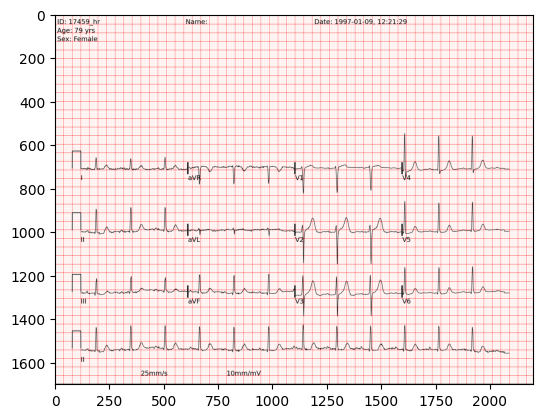

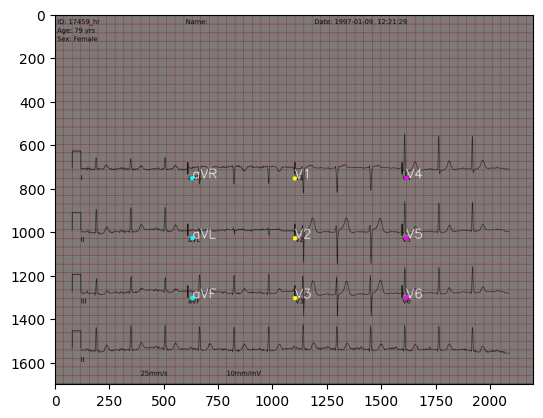

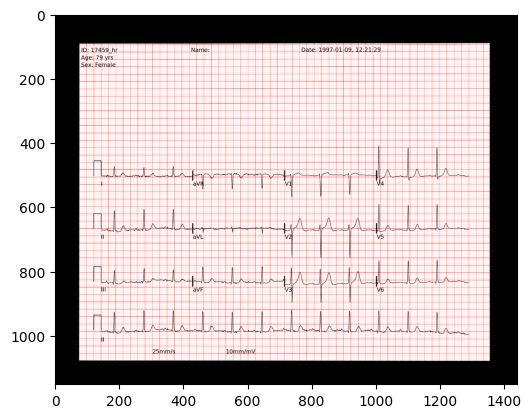

	    1 2352854581  0 min 03 sec
demo results for stage0--------------
2352854581


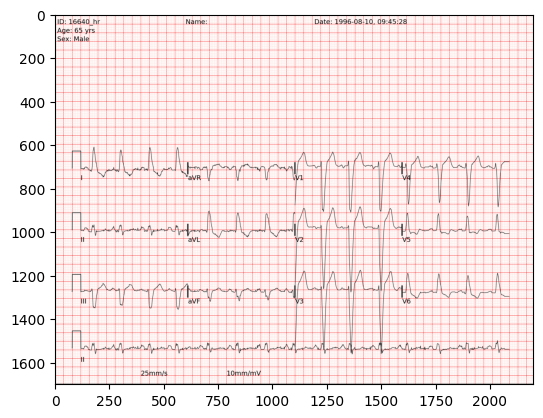

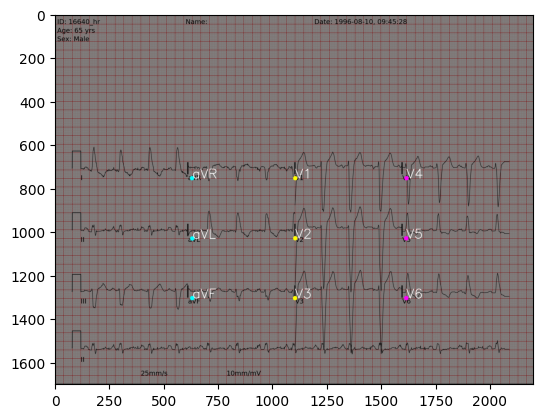

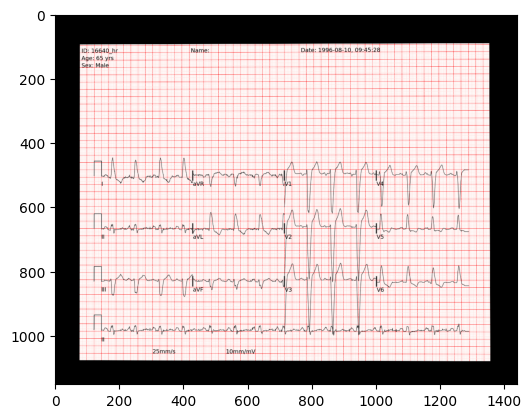


FAIL_ID: []
run_stage0() ok!!!



In [3]:
# stage0
print('*** STARTING STAGE0 ***')

from stage0_model import Net as Stage0Net
from stage0_common import *

os.makedirs(f'{OUT_DIR}/normalised', exist_ok=True)

def run_stage0():
    stage0_net = Stage0Net(pretrained=False)
    stage0_net = load_net(stage0_net, f'{WEIGHT_DIR}/stage0-last.checkpoint.pth')
    stage0_net.to(DEVICE)

    start_timer = timer()
    for n, sample_id in enumerate(valid_id):
        timestamp = time_to_str(timer() - start_timer, 'sec')
        print(f'\r\t {n:4d} {sample_id}', timestamp, end='', flush=True)

        image = read_image(sample_id)
        batch = image_to_batch(image)

        with torch.amp.autocast('cuda', dtype=FLOAT_TYPE):
            with torch.no_grad():
                output = stage0_net(batch)

                try:
                    rotated, keypoint = output_to_predict(image, batch, output)
                    normalised, keypoint, homo = normalise_by_homography(rotated, keypoint)
                    # ---
                    cv2.imwrite(f'{OUT_DIR}/normalised/{sample_id}.norm.png', cv2.cvtColor(normalised, cv2.COLOR_RGB2BGR))
                    np.save(f'{OUT_DIR}/normalised/{sample_id}.homo.npy', homo)
                except:
                    FAIL_ID.append(sample_id)

        torch.cuda.empty_cache()
        if n<10: # optional: show results
            overlay = draw_results_stage0(rotated, keypoint)
            print('')
            print('demo results for stage0--------------')
            print(sample_id)
            plt.imshow(image);plt.show()
            plt.imshow(overlay);plt.show()
            plt.imshow(normalised);plt.show()
            
    print('')

run_stage0()
print('FAIL_ID:', FAIL_ID)
print('run_stage0() ok!!!\n')

*** STARTING STAGE1 ***
/kaggle/input/gavin-submit-physionet
<All keys matched successfully>
	    0 1053922973  0 min 00 sec
demo results for stage1--------------
1053922973


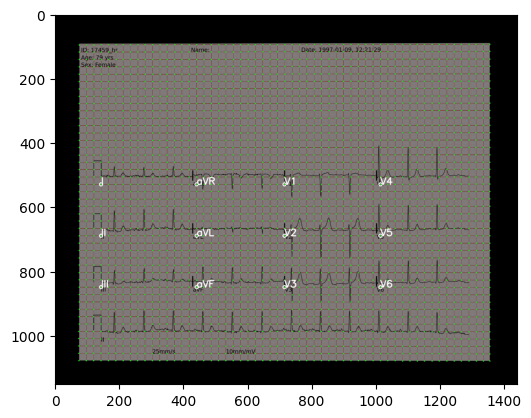

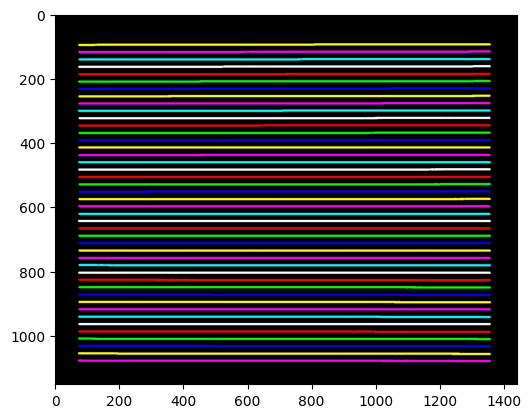

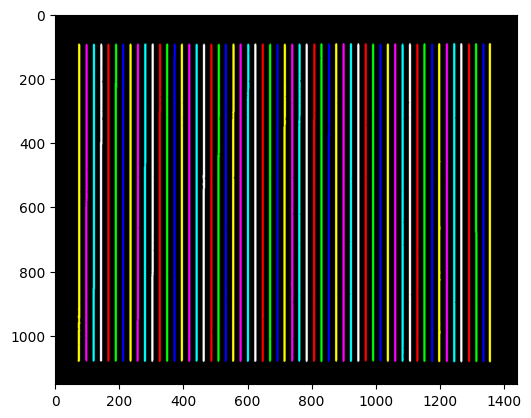

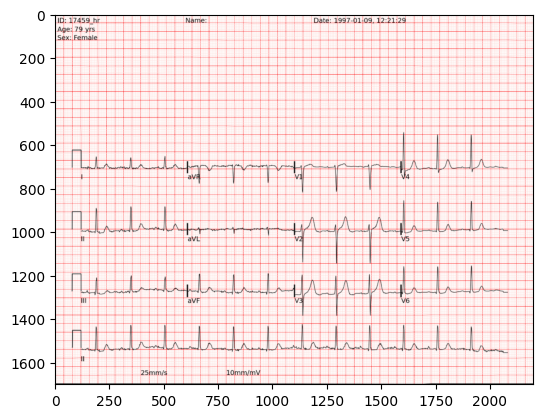

	    1 2352854581  0 min 03 sec
demo results for stage1--------------
2352854581


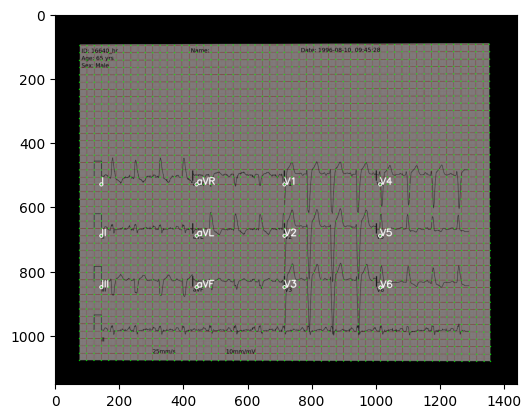

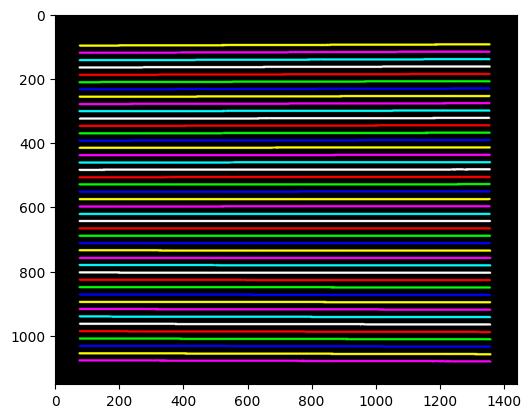

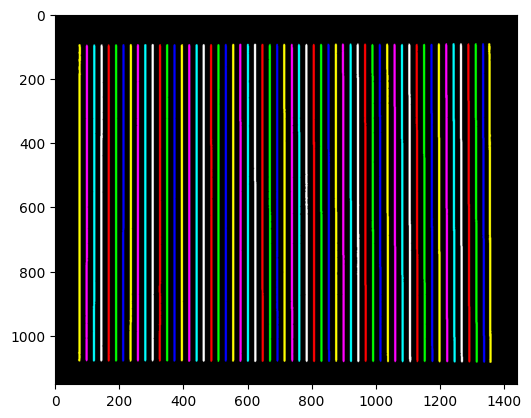

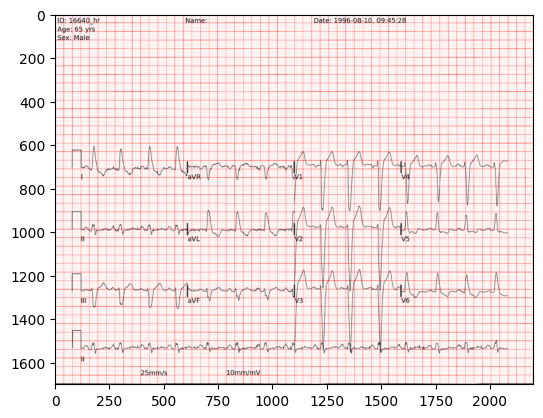


FAIL_ID: []
run_stage1() ok!!!



In [4]:
# stage1
print('*** STARTING STAGE1 ***')

from stage1_common import *
from stage1_unet_points import UNet

os.makedirs(f'{OUT_DIR}/rectified', exist_ok=True)

def remove_module_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("module."):
            new_state_dict[k[7:]] = v   # 去掉 module.
        else:
            new_state_dict[k] = v
    return new_state_dict

def load_model(**kwargs):
    weights_path = kwargs.pop("weights_path", None)
    model = UNet(**kwargs)
    state = torch.load(weights_path, map_location='cpu', weights_only=False) # ['state_dict']
    state = remove_module_prefix(state)
    state = {k.replace("_orig_mod.", ""): v for k, v in state.items()}
    verbose = model.load_state_dict(state, strict=False)
    print(verbose)
    model.eval()
    return model

def run_stage1():
    
    stage1_net = load_model(
        weights_path=f"{WEIGHT_DIR}/stage1-points-e60.pth",
        num_in_channels=3,
        num_out_channels=4,
        dims=[32, 64, 128, 256, 320, 320, 320, 320],
        depth=2,
    )
    stage1_net.to(DEVICE)
    
    start_timer = timer()
    for n, sample_id in enumerate(valid_id):
        timestamp = time_to_str(timer() - start_timer, 'sec')
        print(f'\r\t {n:4d} {sample_id}', timestamp, end='', flush=True)
        if sample_id in FAIL_ID: continue

        image = cv2.imread(f'{OUT_DIR}/normalised/{sample_id}.norm.png', cv2.IMREAD_COLOR_RGB)
        batch = torch.from_numpy(np.ascontiguousarray(image.transpose(2, 0, 1))).unsqueeze(0).to(DEVICE)
        num_tta = 1

        with torch.amp.autocast('cuda', dtype=FLOAT_TYPE): #torch.bfloat16
            with torch.no_grad():
                output = stage1_net(batch)

                try:
                    # gridpoint_xy, more = output_to_predict(image, batch, output)
                    gridpoint_xy, more = output_to_predict_optimized(image, batch, output)
                    rectified = rectify_image(image, gridpoint_xy)
                    # ---
                    cv2.imwrite(f'{OUT_DIR}/rectified/{sample_id}.rect.png', cv2.cvtColor(rectified, cv2.COLOR_RGB2BGR))
                    np.save(f'{OUT_DIR}/rectified/{sample_id}.gridpoint_xy.npy',gridpoint_xy)
                except:
                    FAIL_ID.append(sample_id)

        torch.cuda.empty_cache()
        if n<10: # optional: show results
            overlay = draw_mapping(image, gridpoint_xy) #
            ghfiltered, gvfiltered = draw_results_stage1(more)
            
            
            print('')
            print('demo results for stage1--------------')
            print(sample_id)
            plt.imshow(overlay);plt.show()
            plt.imshow(gvfiltered);plt.show()
            plt.imshow(ghfiltered);plt.show()
            plt.imshow(rectified);plt.show()
             
    print('')

run_stage1()
print('FAIL_ID:', FAIL_ID)
print('run_stage1() ok!!!\n')

*** STARTING STAGE2 ***
/kaggle/input/gavin-submit-physionet
<All keys matched successfully>
	    0 1053922973  0 min 00 sec

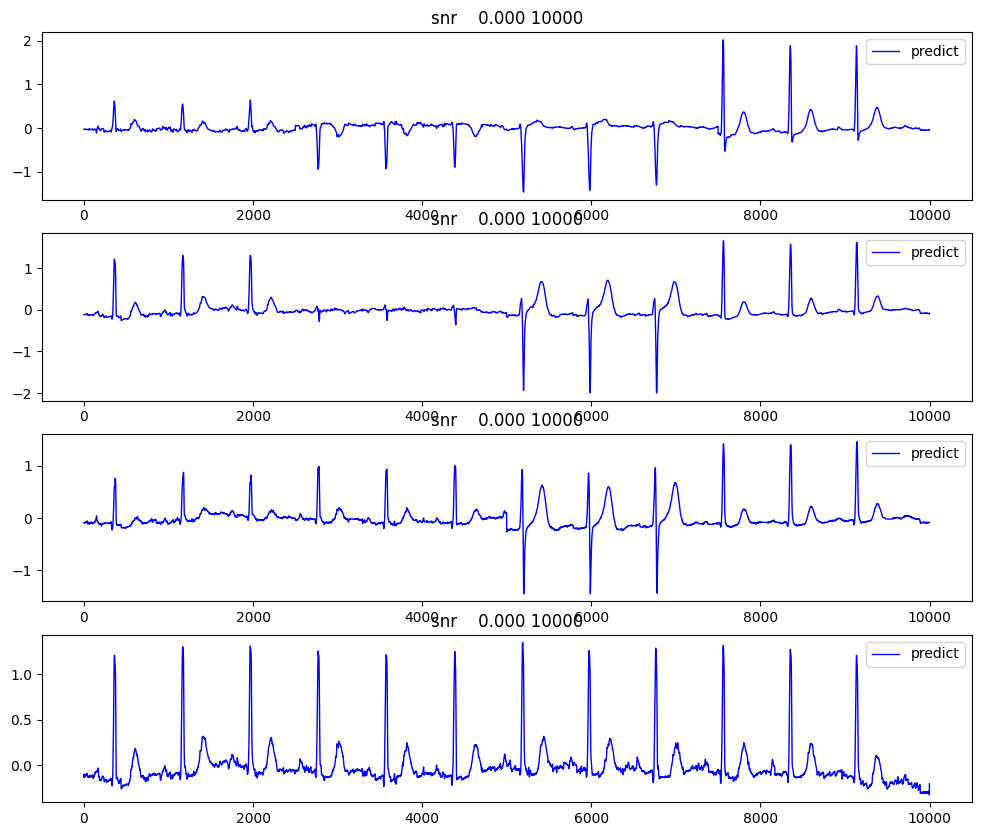

	    1 2352854581  0 min 02 sec

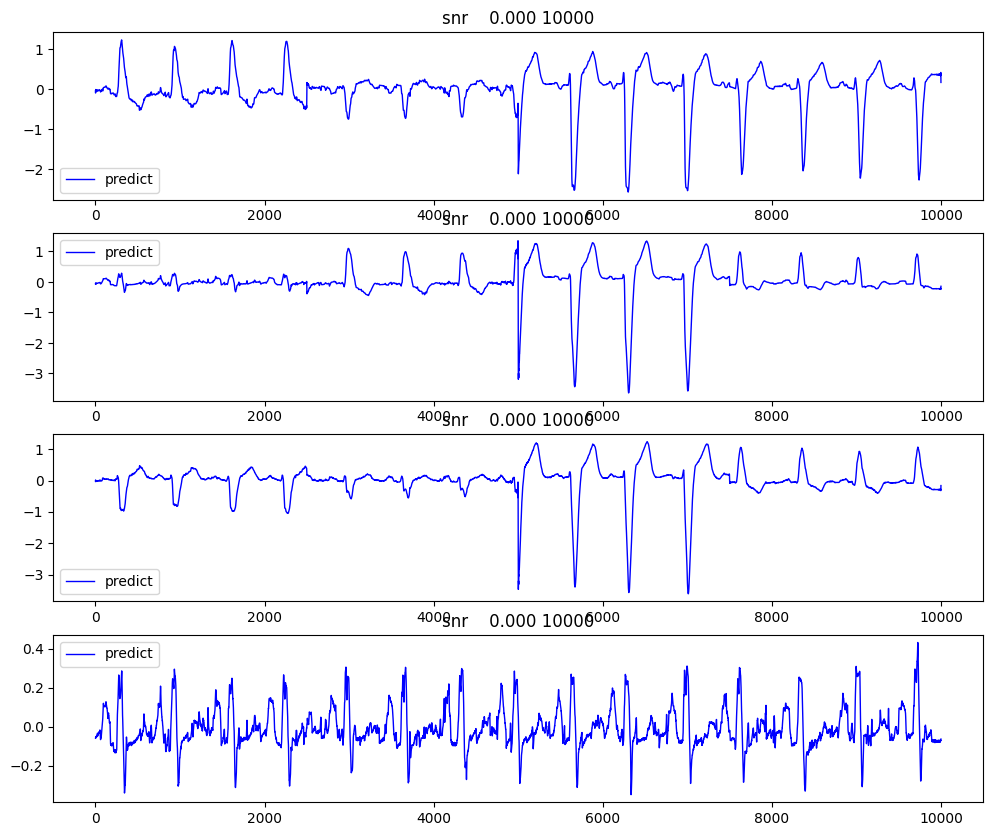


nan
FAIL_ID: []
run_stage2() ok!!!



/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [5]:

# stage2
print('*** STARTING STAGE2 ***')

from stage2_common import *
from stage2_unet_query import UNet

os.makedirs(f'{OUT_DIR}/digitalised', exist_ok=True)
    
def run_stage2():
    stage2_net = load_model(
        weights_path=f"{WEIGHT_DIR}/output.5120.hflip.e150.query.pth",
        num_in_channels=3,
        num_out_channels=4,
        dims=[32, 64, 128, 256, 320, 320, 320, 320],
        depth=2,
    )
    stage2_net.to(DEVICE)

    
    snr_list = []
    start_timer = timer()
    for n, sample_id in enumerate(valid_id):
        
        timestamp = time_to_str(timer() - start_timer, 'sec')
        print(f'\r\t {n:4d} {sample_id}', timestamp, end='', flush=True)
        if sample_id in FAIL_ID: continue

        x0, x1 = 0, 2176
        y0, y1 = 0, 1696
        zero_mv = [703.5, 987.5, 1271.5, 1531.5]
        mv_to_pixel = 79
        t0, t1 = timespan = 118, 2080

        image = cv2.imread(f'{OUT_DIR}/rectified/{sample_id}.rect.png', cv2.IMREAD_COLOR_RGB)
        length = read_sampling_length(sample_id) #5120

        crop = image[y0:y1, x0:x1][:, t0:t1]
        
        H, W, C = crop.shape
        input_tensor = torch.from_numpy(np.ascontiguousarray(crop.transpose(2, 0, 1))).unsqueeze(0) / 255.0
        input_tensor = input_tensor.to(DEVICE)
        
        with torch.amp.autocast('cuda', dtype=FLOAT_TYPE):
            with torch.no_grad():
                output = stage2_net(input_tensor, target_len=5120)

                # hflip tta
                input_hflip = torch.flip(input_tensor, dims=[3])
                out_hflip = stage2_net(input_hflip, target_len=5120)

        L = output['prob'].shape[-1]
        series = output[f'y_mv_{L}']
   
        # hflip tta
        series_hflip = torch.flip(out_hflip[f'y_mv_{L}'], dims=[2])

        # tta average
        series = (series + series_hflip) / 2.0
        
        
        if L != length:
            series = stage2_net.signal_head.resample_torch(x=series, num=length)

        series = series[0].cpu().numpy()
            
        np.save(f'{OUT_DIR}/digitalised/{sample_id}.series.npy', series)


        if n<20: 
            
            if MODE=='local':
                truth_df = read_truth_series(sample_id,KAGGLE_DIR)
                truth_series = truth_df[['series0','series1','series2','series3',]].values.T

            t = np.arange(len(series[0]))
            fig, axes = plt.subplots(4, 1, figsize=(12, 10))
            for j in range(4):
                snr=0
                axes[j].plot(t, series[j], alpha=1.0, color='blue', linewidth=1, label='predict')
                if MODE=='local':
                    axes[j].plot(t, truth_series[j], alpha=0.5, color='red', linewidth=1,label='truth')
                    snr = -np_snr(series[j], truth_series[j])
                    snr_list.append(snr)

                axes[j].set_title(f'snr {snr:8.3f} {length}')
                axes[j].legend()
            plt.show()
    print('')
    print(np.mean(snr_list))
    
run_stage2()
print('FAIL_ID:', FAIL_ID)
print('run_stage2() ok!!!\n')

*** STARTING STAGE2 ***
<All keys matched successfully>
	    0 1053922973  0 min 00 sec

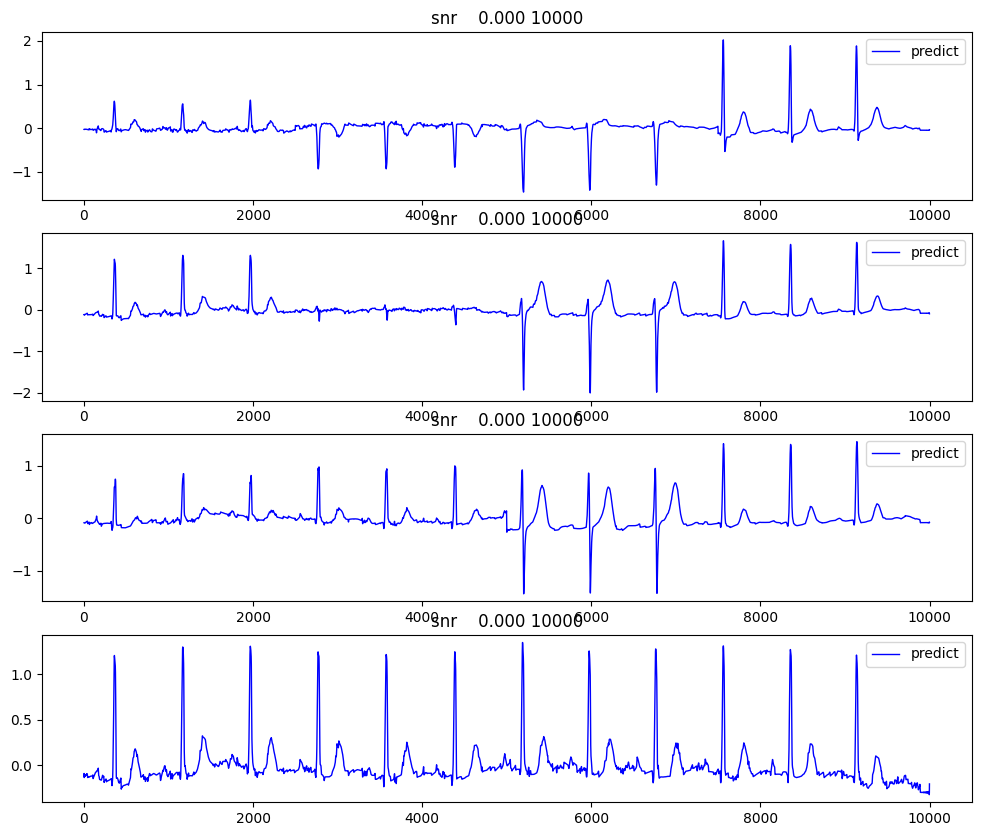

	    1 2352854581  0 min 02 sec

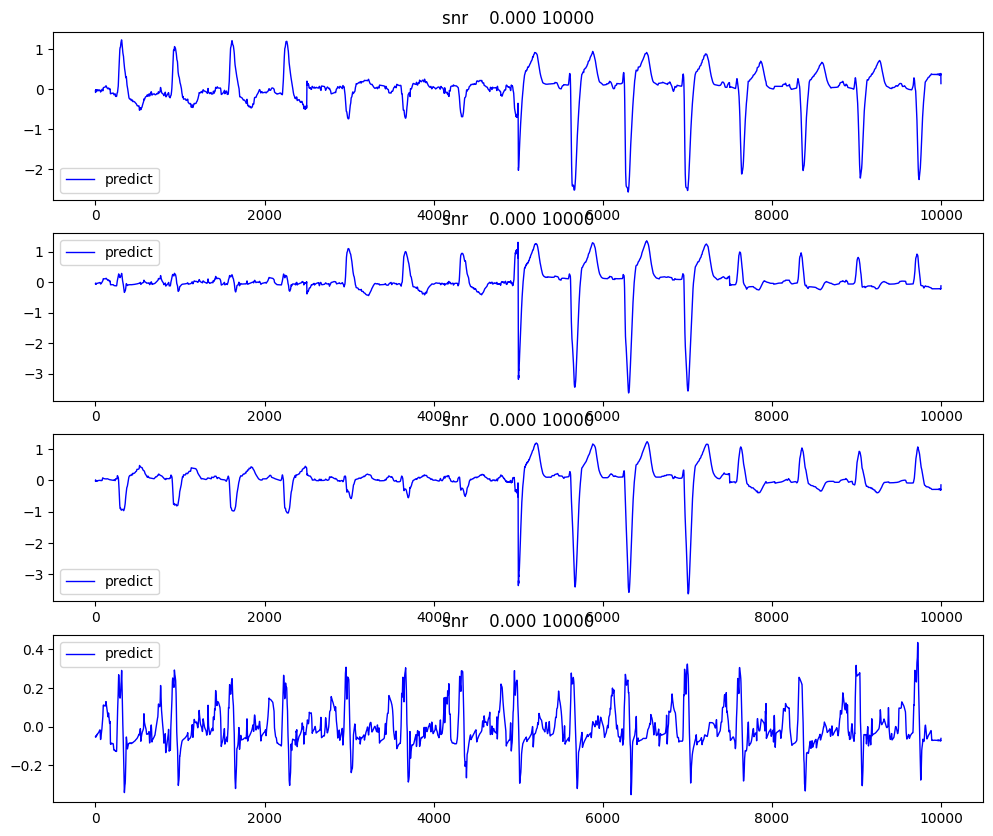


nan
FAIL_ID: []
run_stage2() ok!!!



In [6]:

# stage2
print('*** STARTING STAGE2 ***')
from stage2_common import *
from stage2_unet import UNet

os.makedirs(f'{OUT_DIR}/digitalised', exist_ok=True)
    
def run_stage2():
    stage2_net = load_model(
        weights_path=f"{WEIGHT_DIR}/ckpt-5120-full-hflip-e150.pth",
        num_in_channels=3,
        num_out_channels=4,
        dims=[32, 64, 128, 256, 320, 320, 320, 320],
        depth=2,
    )
    stage2_net.to(DEVICE)

    
    snr_list = []
    start_timer = timer()
    for n, sample_id in enumerate(valid_id):

        timestamp = time_to_str(timer() - start_timer, 'sec')
        print(f'\r\t {n:4d} {sample_id}', timestamp, end='', flush=True)
        if sample_id in FAIL_ID: continue

        x0, x1 = 0, 2176
        y0, y1 = 0, 1696
        zero_mv = [703.5, 987.5, 1271.5, 1531.5]
        mv_to_pixel = 79
        t0, t1 = timespan = 118, 2080

        image = cv2.imread(f'{OUT_DIR}/rectified/{sample_id}.rect.png', cv2.IMREAD_COLOR_RGB)
        length = read_sampling_length(sample_id) #5120

        crop = image[y0:y1, x0:x1][:, t0:t1]

        H, W, C = crop.shape
        input_tensor = torch.from_numpy(np.ascontiguousarray(crop.transpose(2, 0, 1))).unsqueeze(0) / 255.0
        input_tensor = input_tensor.to(DEVICE)
        
        with torch.amp.autocast('cuda', dtype=FLOAT_TYPE):
            with torch.no_grad():
                output = stage2_net(input_tensor, resample_length=5120)

                # hflip tta
                input_hflip = torch.flip(input_tensor, dims=[3])
                out_hflip = stage2_net(input_hflip, resample_length=5120)

        L = output['prob'].shape[-1]
        series = output[f'y_mv_{L}']

        # hflip tta
        series_hflip = torch.flip(out_hflip[f'y_mv_{L}'], dims=[2])

        # tta average
        series = (series + series_hflip) / 2.0
    
        if L != length:
            series = stage2_net.signal_head.resample_torch(x=series, num=length)

        series = series[0].cpu().numpy()
            
        np.save(f'{OUT_DIR}/digitalised/{sample_id}.series.v2.npy', series)


        if n<20: # optional: show results
            # overlay = draw_lead_pixel(crop, pixel)
            # plt.imshow(overlay); plt.show()
     
            if MODE=='local':
                truth_df = read_truth_series(sample_id,KAGGLE_DIR)
                truth_series = truth_df[['series0','series1','series2','series3',]].values.T

            t = np.arange(len(series[0]))
            fig, axes = plt.subplots(4, 1, figsize=(12, 10))
            for j in range(4):
                snr=0
                axes[j].plot(t, series[j], alpha=1.0, color='blue', linewidth=1, label='predict')
                if MODE=='local':
                    axes[j].plot(t, truth_series[j], alpha=0.5, color='red', linewidth=1,label='truth')
                    snr = -np_snr(series[j], truth_series[j])
                    snr_list.append(snr)

                axes[j].set_title(f'snr {snr:8.3f} {length}')
                axes[j].legend()
            plt.show()
    print('')
    print(np.mean(snr_list))
    
run_stage2()
print('FAIL_ID:', FAIL_ID)
print('run_stage2() ok!!!\n')

*** STARTING STAGE2 ***
<All keys matched successfully>
	    0 1053922973  0 min 00 sec

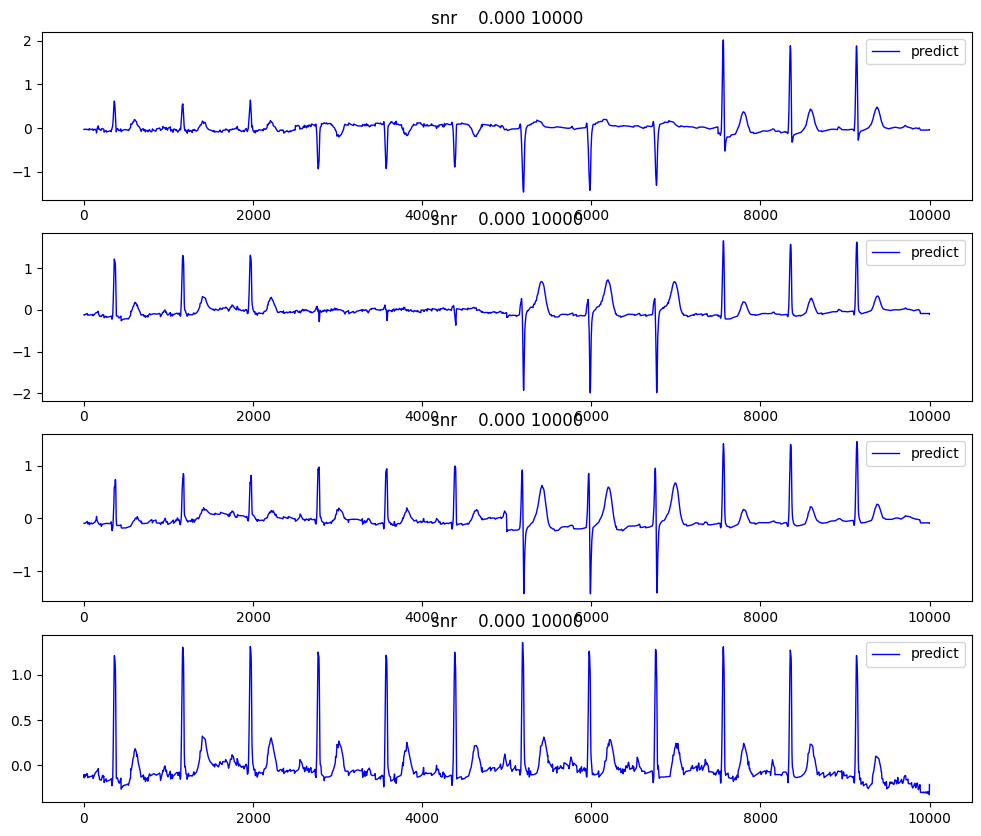

	    1 2352854581  0 min 02 sec

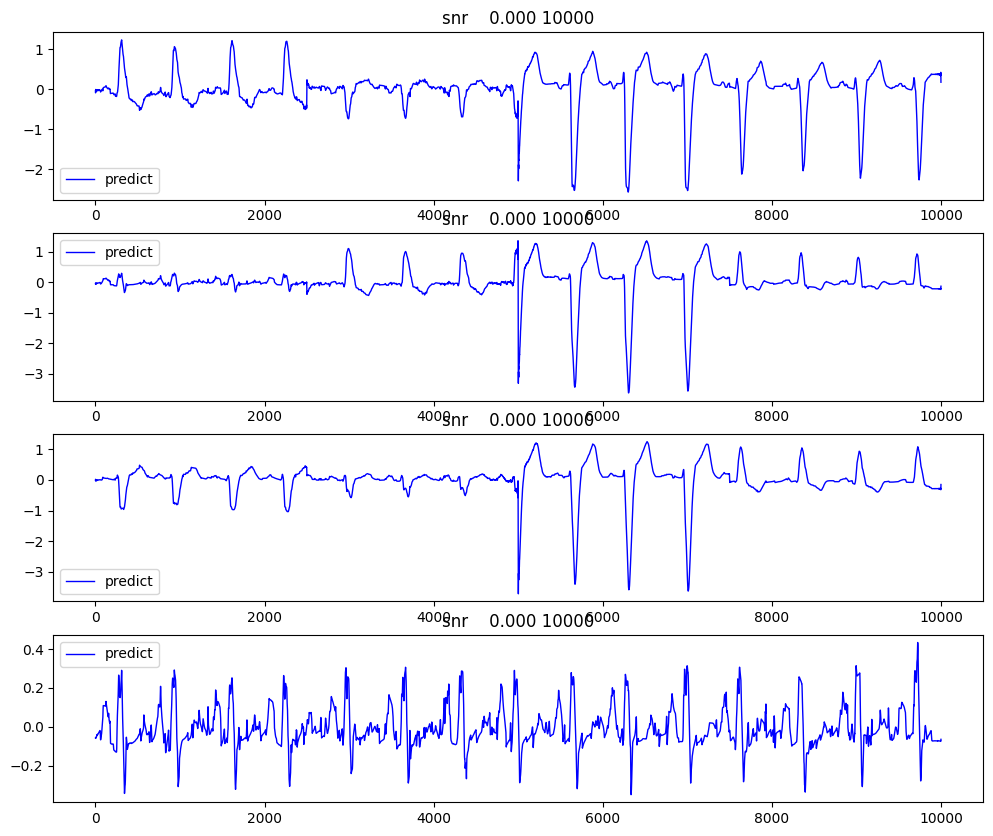


nan
FAIL_ID: []
run_stage2() ok!!!



In [7]:

# stage2
print('*** STARTING STAGE2 ***')

from stage2_common import *
from stage2_unet import UNet

os.makedirs(f'{OUT_DIR}/digitalised', exist_ok=True)
    
def run_stage2():
    stage2_net = load_model(
        weights_path=f"{WEIGHT_DIR}/ckpt-5120-full-extra-e80-hflip.pth",
        num_in_channels=3,
        num_out_channels=4,
        dims=[32, 64, 128, 256, 320, 320, 320, 320],
        depth=2,
    )
    stage2_net.to(DEVICE)

    
    snr_list = []
    start_timer = timer()
    for n, sample_id in enumerate(valid_id):

        timestamp = time_to_str(timer() - start_timer, 'sec')
        print(f'\r\t {n:4d} {sample_id}', timestamp, end='', flush=True)
        if sample_id in FAIL_ID: continue

        x0, x1 = 0, 2176
        y0, y1 = 0, 1696
        zero_mv = [703.5, 987.5, 1271.5, 1531.5]
        mv_to_pixel = 79
        t0, t1 = timespan = 118, 2080

        image = cv2.imread(f'{OUT_DIR}/rectified/{sample_id}.rect.png', cv2.IMREAD_COLOR_RGB)
        length = read_sampling_length(sample_id) #5120

        crop = image[y0:y1, x0:x1][:, t0:t1]
        
        H, W, C = crop.shape
        input_tensor = torch.from_numpy(np.ascontiguousarray(crop.transpose(2, 0, 1))).unsqueeze(0) / 255.0
        input_tensor = input_tensor.to(DEVICE)
        
        with torch.amp.autocast('cuda', dtype=FLOAT_TYPE):
            with torch.no_grad():
                output = stage2_net(input_tensor, resample_length=5120)

                # hflip tta
                input_hflip = torch.flip(input_tensor, dims=[3])
                out_hflip = stage2_net(input_hflip, resample_length=5120)

        L = output['prob'].shape[-1]
        series = output[f'y_mv_{L}']

        # hflip tta
        series_hflip = torch.flip(out_hflip[f'y_mv_{L}'], dims=[2])

        # tta average
        series = (series + series_hflip) / 2.0
        
        
        if L != length:
            series = stage2_net.signal_head.resample_torch(x=series, num=length)

        series = series[0].cpu().numpy()
            
        np.save(f'{OUT_DIR}/digitalised/{sample_id}.series.v3.npy', series)


        if n<20: # optional: show results

            if MODE=='local':
                truth_df = read_truth_series(sample_id,KAGGLE_DIR)
                truth_series = truth_df[['series0','series1','series2','series3',]].values.T

            t = np.arange(len(series[0]))
            fig, axes = plt.subplots(4, 1, figsize=(12, 10))
            for j in range(4):
                snr=0
                axes[j].plot(t, series[j], alpha=1.0, color='blue', linewidth=1, label='predict')
                if MODE=='local':
                    axes[j].plot(t, truth_series[j], alpha=0.5, color='red', linewidth=1,label='truth')
                    snr = -np_snr(series[j], truth_series[j])
                    snr_list.append(snr)

                axes[j].set_title(f'snr {snr:8.3f} {length}')
                axes[j].legend()
            plt.show()
    print('')
    print(np.mean(snr_list))
    
run_stage2()
print('FAIL_ID:', FAIL_ID)
print('run_stage2() ok!!!\n')

*** STARTING STAGE2 ***
<All keys matched successfully>
	    0 1053922973  0 min 00 sec

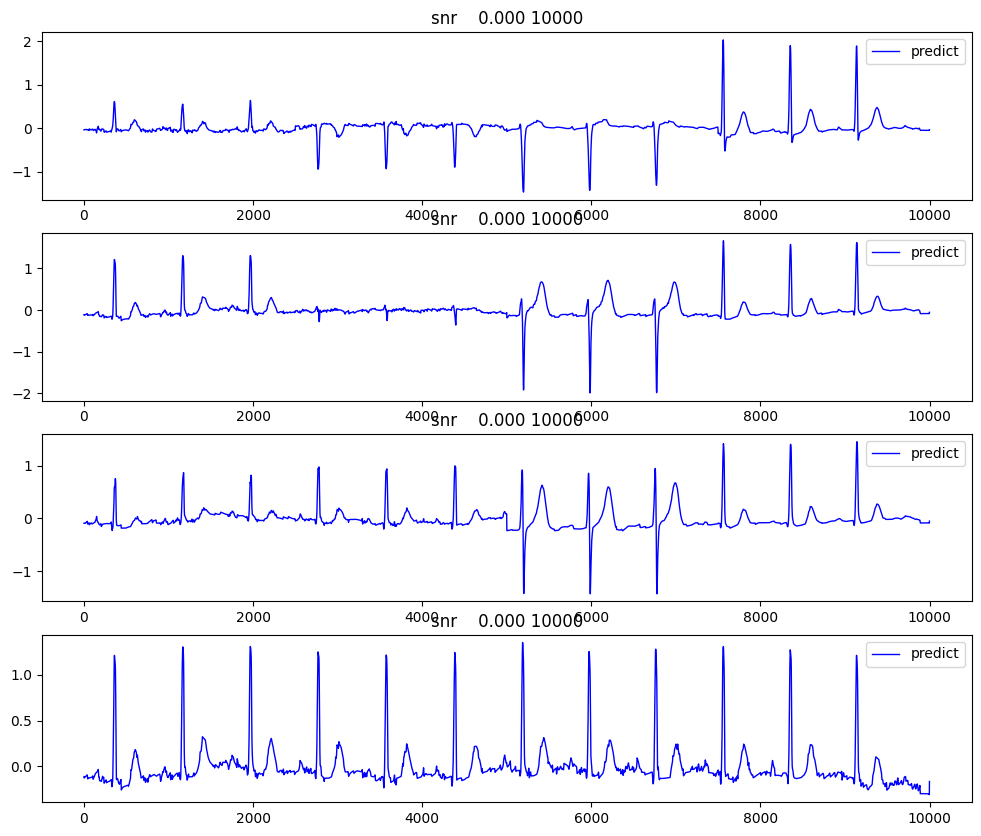

	    1 2352854581  0 min 04 sec

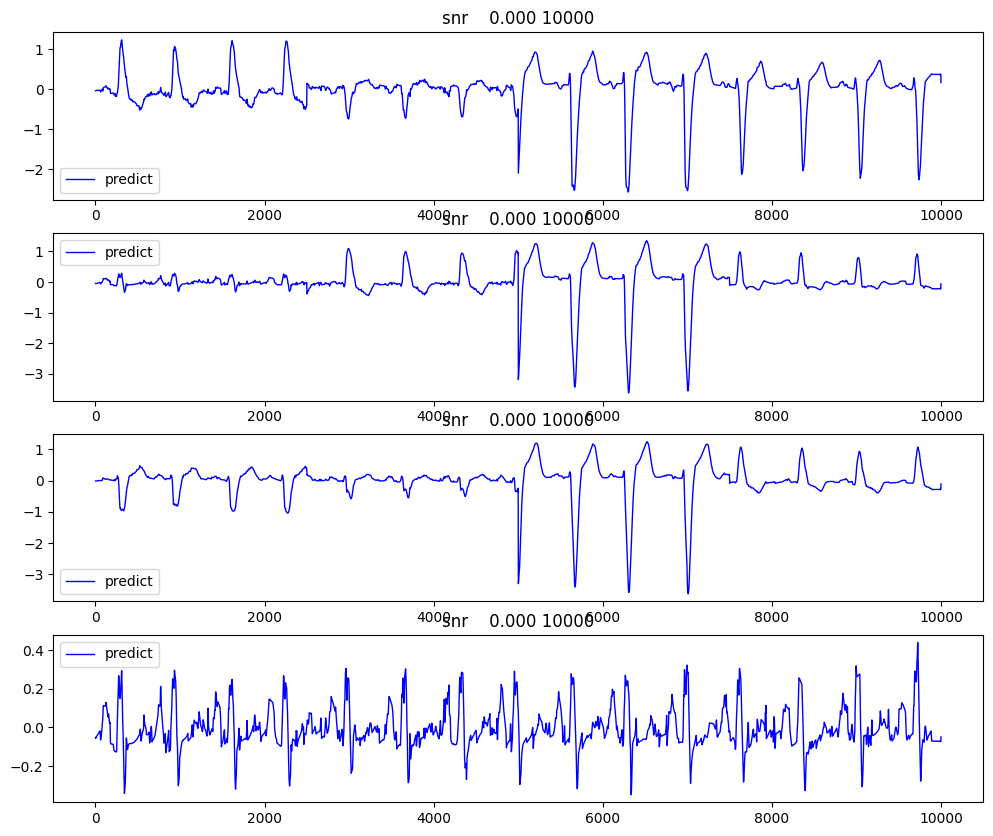


nan
FAIL_ID: []
run_stage2() ok!!!



In [8]:
# stage2
print('*** STARTING STAGE2 ***')

from stage2_common import *
from stage2_unet_split import UNet

os.makedirs(f'{OUT_DIR}/digitalised', exist_ok=True)

    
def run_stage2():
    stage2_net = load_model(
        weights_path=f"{WEIGHT_DIR}/ckpt.full.10250.split.e70.pth",
        num_in_channels=3,
        num_out_channels=4,
        dims=[32, 64, 128, 256, 320, 320, 320, 320],
        depth=2,
    )
    stage2_net.to(DEVICE)

    
    snr_list = []
    start_timer = timer()
    for n, sample_id in enumerate(valid_id):

        timestamp = time_to_str(timer() - start_timer, 'sec')
        print(f'\r\t {n:4d} {sample_id}', timestamp, end='', flush=True)
        if sample_id in FAIL_ID: continue

        x0, x1 = 0, 2176
        y0, y1 = 0, 1696
        zero_mv = [703.5, 987.5, 1271.5, 1531.5]
        mv_to_pixel = 79
        t0, t1 = timespan = 118, 2080

        image = cv2.imread(f'{OUT_DIR}/rectified/{sample_id}.rect.png', cv2.IMREAD_COLOR_RGB)
    
        length = read_sampling_length(sample_id) #5120

        crop = image[y0:y1, x0:x1][:, t0:t1]
        
        H, W, C = crop.shape
        input_tensor = torch.from_numpy(np.ascontiguousarray(crop.transpose(2, 0, 1))).unsqueeze(0) / 255.0
        input_tensor = input_tensor.to(DEVICE)

        L = 10250
        
        with torch.amp.autocast('cuda', dtype=FLOAT_TYPE):
            with torch.no_grad():
                output = stage2_net(input_tensor, resample_length=L)

                # hflip tta
                input_hflip = torch.flip(input_tensor, dims=[3])
                out_hflip = stage2_net(input_hflip, resample_length=L)

        series = output[f'y_mv_{L}']

        # hflip tta
        series_hflip = torch.flip(out_hflip[f'y_mv_{L}'], dims=[2])

        # tta average
        series = (series + series_hflip) / 2.0
        
        
        if L != length:
            series = stage2_net.signal_head.resample_torch(x=series, num=length)

        series = series[0].cpu().numpy()
            
        np.save(f'{OUT_DIR}/digitalised/{sample_id}.series.v4.npy', series)


        if n<20: # optional: show results

            if MODE=='local':
                truth_df = read_truth_series(sample_id,KAGGLE_DIR)
                truth_series = truth_df[['series0','series1','series2','series3',]].values.T

            t = np.arange(len(series[0]))
            fig, axes = plt.subplots(4, 1, figsize=(12, 10))
            for j in range(4):
                snr=0
                axes[j].plot(t, series[j], alpha=1.0, color='blue', linewidth=1, label='predict')
                if MODE=='local':
                    axes[j].plot(t, truth_series[j], alpha=0.5, color='red', linewidth=1,label='truth')
                    snr = -np_snr(series[j], truth_series[j])
                    snr_list.append(snr)

                axes[j].set_title(f'snr {snr:8.3f} {length}')
                axes[j].legend()
            plt.show()
    print('')
    print(np.mean(snr_list))
    
run_stage2()
print('FAIL_ID:', FAIL_ID)
print('run_stage2() ok!!!\n')

*** STARTING STAGE2 ***
<All keys matched successfully>
	    0 1053922973  0 min 00 sec

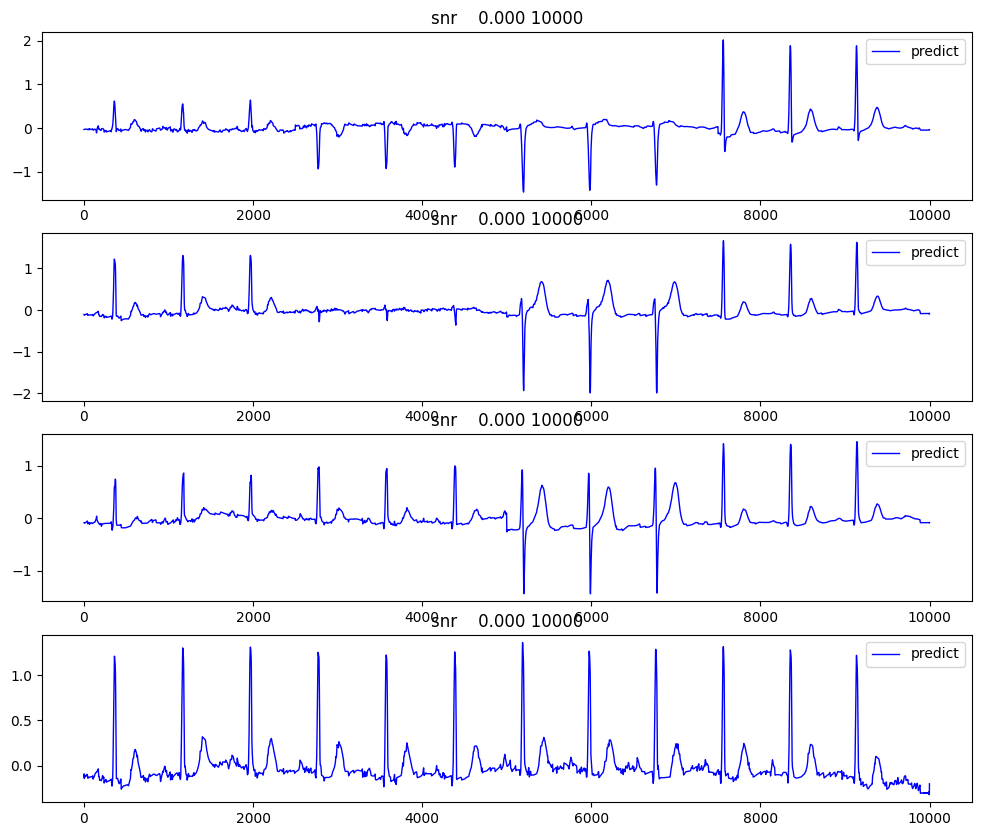

	    1 2352854581  0 min 02 sec

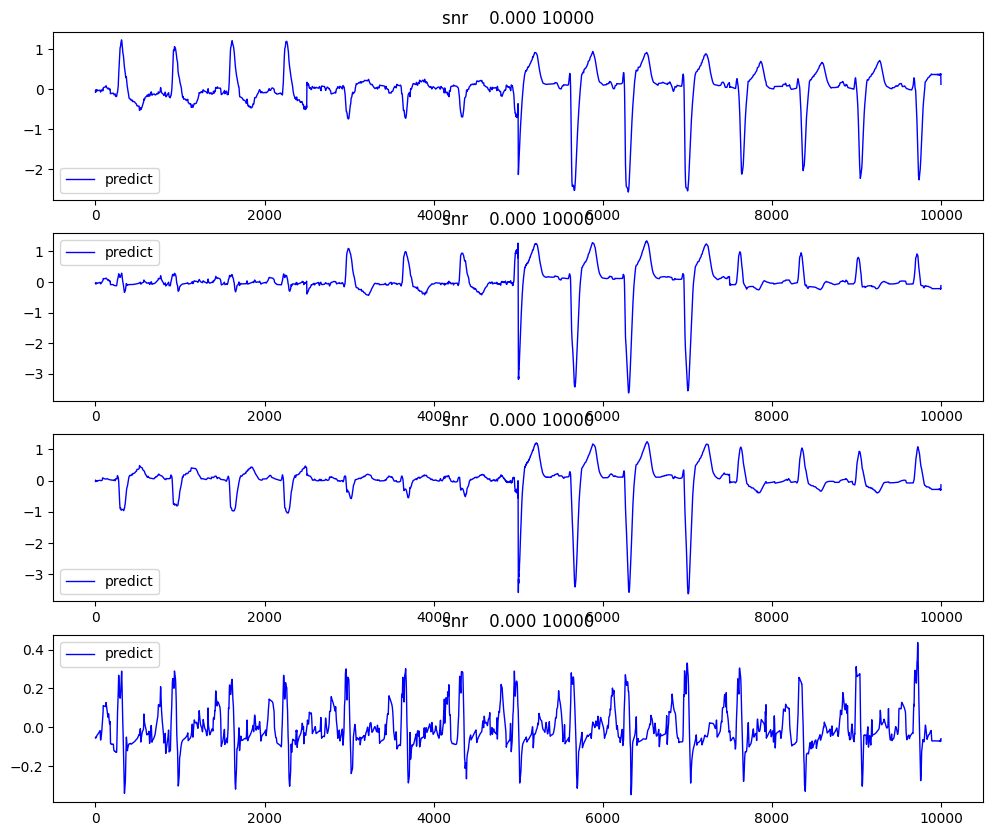


nan
FAIL_ID: []
run_stage2() ok!!!



In [9]:

# stage2
print('*** STARTING STAGE2 ***')

from stage2_common import *
from stage2_unet import UNet

os.makedirs(f'{OUT_DIR}/digitalised', exist_ok=True)
    
def run_stage2():
    stage2_net = load_model(
        weights_path=f"{WEIGHT_DIR}/ckpt-5120-full-pretrain-e100-hflip.pth",
        num_in_channels=3,
        num_out_channels=4,
        dims=[32, 64, 128, 256, 320, 320, 320, 320],
        depth=2,
    )
    stage2_net.to(DEVICE)

    
    snr_list = []
    start_timer = timer()
    for n, sample_id in enumerate(valid_id):

        timestamp = time_to_str(timer() - start_timer, 'sec')
        print(f'\r\t {n:4d} {sample_id}', timestamp, end='', flush=True)
        if sample_id in FAIL_ID: continue

        x0, x1 = 0, 2176
        y0, y1 = 0, 1696
        zero_mv = [703.5, 987.5, 1271.5, 1531.5]
        mv_to_pixel = 79
        t0, t1 = timespan = 118, 2080

        image = cv2.imread(f'{OUT_DIR}/rectified/{sample_id}.rect.png', cv2.IMREAD_COLOR_RGB)
        length = read_sampling_length(sample_id) #5120

        crop = image[y0:y1, x0:x1][:, t0:t1]

        H, W, C = crop.shape
        input_tensor = torch.from_numpy(np.ascontiguousarray(crop.transpose(2, 0, 1))).unsqueeze(0) / 255.0
        input_tensor = input_tensor.to(DEVICE)
        
        with torch.amp.autocast('cuda', dtype=FLOAT_TYPE):
            with torch.no_grad():
                output = stage2_net(input_tensor, resample_length=5120)

                # hflip tta
                input_hflip = torch.flip(input_tensor, dims=[3])
                out_hflip = stage2_net(input_hflip, resample_length=5120)

        L = output['prob'].shape[-1]
        series = output[f'y_mv_{L}']

        # hflip tta
        series_hflip = torch.flip(out_hflip[f'y_mv_{L}'], dims=[2])

        # tta average
        series = (series + series_hflip) / 2.0
        
        
        if L != length:
            series = stage2_net.signal_head.resample_torch(x=series, num=length)

        series = series[0].cpu().numpy()
            
        np.save(f'{OUT_DIR}/digitalised/{sample_id}.series.v5.npy', series)


        if n<20: # optional: show results

            if MODE=='local':
                truth_df = read_truth_series(sample_id,KAGGLE_DIR)
                truth_series = truth_df[['series0','series1','series2','series3',]].values.T

            t = np.arange(len(series[0]))
            fig, axes = plt.subplots(4, 1, figsize=(12, 10))
            for j in range(4):
                snr=0
                axes[j].plot(t, series[j], alpha=1.0, color='blue', linewidth=1, label='predict')
                if MODE=='local':
                    axes[j].plot(t, truth_series[j], alpha=0.5, color='red', linewidth=1,label='truth')
                    snr = -np_snr(series[j], truth_series[j])
                    snr_list.append(snr)

                axes[j].set_title(f'snr {snr:8.3f} {length}')
                axes[j].legend()
            plt.show()
    print('')
    print(np.mean(snr_list))
    
run_stage2()
print('FAIL_ID:', FAIL_ID)
print('run_stage2() ok!!!\n')

*** STARTING STAGE2 ***
<All keys matched successfully>
	    0 1053922973  0 min 00 sec

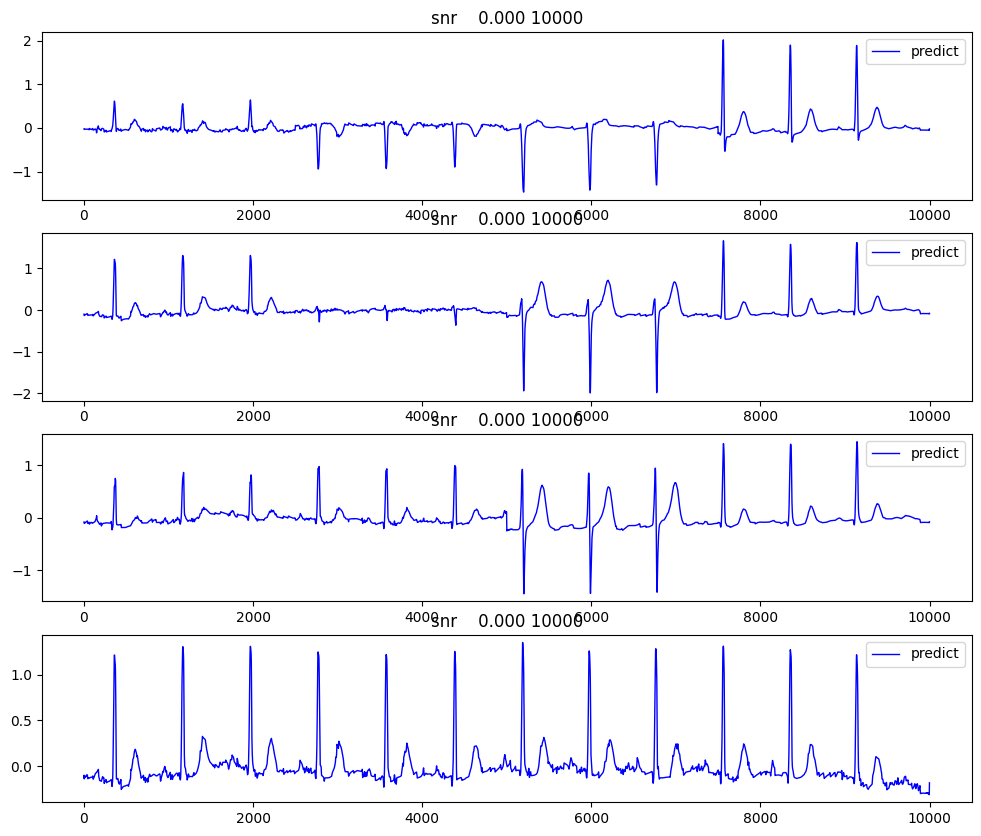

	    1 2352854581  0 min 02 sec

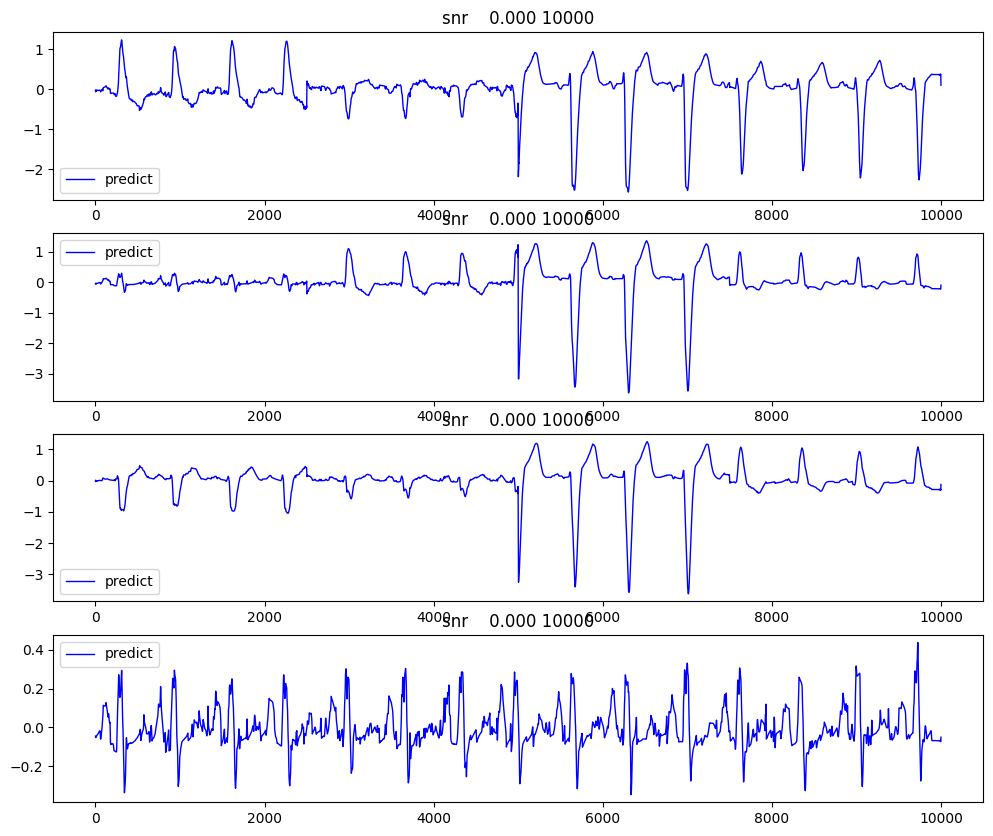


nan
FAIL_ID: []
run_stage2() ok!!!



In [10]:
# stage2
print('*** STARTING STAGE2 ***')

from stage2_common import *
from stage2_unet_heng import Net

os.makedirs(f'{OUT_DIR}/digitalised', exist_ok=True)

    
def run_stage2():

    stage2_net = Net(pretrained=False)

    state = torch.load(
        f"{WEIGHT_DIR}/ckpt.heng.5120.full.hflip.e140.pth", 
        map_location='cpu'
    )
    state = {k.replace("_orig_mod.", ""): v for k, v in state.items()}
    verbose = stage2_net.load_state_dict(state, strict=False)
    print(verbose)
    stage2_net.to(DEVICE)
    

    
    snr_list = []
    start_timer = timer()
    for n, sample_id in enumerate(valid_id):

        timestamp = time_to_str(timer() - start_timer, 'sec')
        print(f'\r\t {n:4d} {sample_id}', timestamp, end='', flush=True)
        if sample_id in FAIL_ID: continue

        x0, x1 = 0, 2176
        y0, y1 = 0, 1696
        zero_mv = [703.5, 987.5, 1271.5, 1531.5]
        mv_to_pixel = 79
        t0, t1 = timespan = 118, 2080

        image = cv2.imread(f'{OUT_DIR}/rectified/{sample_id}.rect.png', cv2.IMREAD_COLOR_RGB)
    
        length = read_sampling_length(sample_id) #5120

        crop = image[y0:y1, x0:x1][:, t0:t1]
        
        H, W, C = crop.shape
        input_tensor = torch.from_numpy(np.ascontiguousarray(crop.transpose(2, 0, 1))).unsqueeze(0) / 255.0
        input_tensor = input_tensor.to(DEVICE)

        L = 5120 # 10250
        
        with torch.amp.autocast('cuda', dtype=FLOAT_TYPE):
            with torch.no_grad():
                output = stage2_net(input_tensor, resample_length=L)

                # hflip tta
                input_hflip = torch.flip(input_tensor, dims=[3])
                out_hflip = stage2_net(input_hflip, resample_length=L)

        series = output[f'y_mv_{L}']

        # hflip tta
        series_hflip = torch.flip(out_hflip[f'y_mv_{L}'], dims=[2])

        # tta average
        series = (series + series_hflip) / 2.0
        
        
        if L != length:
            series = stage2_net.signal_head.resample_torch(x=series, num=length)

        series = series[0].cpu().numpy()
            
        np.save(f'{OUT_DIR}/digitalised/{sample_id}.series.v6.npy', series)


        if n<20: # optional: show results

            if MODE=='local':
                truth_df = read_truth_series(sample_id,KAGGLE_DIR)
                truth_series = truth_df[['series0','series1','series2','series3',]].values.T

            t = np.arange(len(series[0]))
            fig, axes = plt.subplots(4, 1, figsize=(12, 10))
            for j in range(4):
                snr=0
                axes[j].plot(t, series[j], alpha=1.0, color='blue', linewidth=1, label='predict')
                if MODE=='local':
                    axes[j].plot(t, truth_series[j], alpha=0.5, color='red', linewidth=1,label='truth')
                    snr = -np_snr(series[j], truth_series[j])
                    snr_list.append(snr)

                axes[j].set_title(f'snr {snr:8.3f} {length}')
                axes[j].legend()
            plt.show()
    print('')
    print(np.mean(snr_list))
    
run_stage2()
print('FAIL_ID:', FAIL_ID)
print('run_stage2() ok!!!\n')

In [11]:
#make sbmission csv
def make_submission():
    print('===========================================')
    print('making submission csv ...')

    submit_df=[]
    gb = valid_df.groupby('id')
    for i,(sample_id, df) in enumerate(gb):
        
        try:
            series_v1 = np.load(f'{OUT_DIR}/digitalised/{sample_id}.series.npy')
            series_v2 = np.load(f'{OUT_DIR}/digitalised/{sample_id}.series.v2.npy')
            series_v3 = np.load(f'{OUT_DIR}/digitalised/{sample_id}.series.v3.npy')
            series_v4 = np.load(f'{OUT_DIR}/digitalised/{sample_id}.series.v4.npy')
            series_v5 = np.load(f'{OUT_DIR}/digitalised/{sample_id}.series.v5.npy')
            series_v6 = np.load(f'{OUT_DIR}/digitalised/{sample_id}.series.v6.npy')

            series = (series_v1 * 0.17 + series_v2 * 0.18 + series_v3 * 0.17 + series_v4 * 0.15 + series_v5 * 0.18 + series_v6 * 0.15)

            series_by_lead={}
            for l in range(3):
                lead = [
                    ['I',   'aVR', 'V1', 'V4'],
                    ['II',  'aVL', 'V2', 'V5'],
                    ['III', 'aVF', 'V3', 'V6'],
                ][l]

                length=[
                    df[df['lead']==lead[j]].iloc[0].number_of_rows
                    for j in range(4)
                ]
                if lead[0]=='II':
                    length[0] = length[0]-sum(length[1:])

                index = np.cumsum(length)[:-1]
                split = np.split(series[l], index)
                #print(length)
                for (k, s) in zip(lead, split):
                    series_by_lead[k] = s
                    #print(k,len(s))
            series_by_lead['II'] = series[3]
            #print(series_by_lead)
    
        except: 
            series_by_lead = {}
            for j,d in df.iterrows():
                series_by_lead[d.lead] = np.zeros(d.number_of_rows)

        for j,d in df.iterrows():

            #probably error here ... ???
            series_by_lead[d.lead] = np.concatenate([
                series_by_lead[d.lead], np.zeros_like(series_by_lead[d.lead])
            ])[:d.number_of_rows]
            assert(len(series_by_lead[d.lead])==d.number_of_rows) 
            print(f'\r\t {i} {sample_id} : {d.lead}', end='', flush=True)

            row_id = [
                f'{sample_id}_{i}_{d.lead}' for i in range(d.number_of_rows)
            ]
            this_df = pd.DataFrame({
                'id':row_id,
                'value': series_by_lead[d.lead].astype(np.float32),
            })
            submit_df.append(this_df)

    print('')
    submit_df = pd.concat(submit_df, axis=0, ignore_index=True, sort=False, copy=False)
    print(submit_df)
    submit_df.to_csv('submission.csv',index=False)

if (MODE=='fake')|(MODE=='submit'):
    make_submission()
    print('make_submission() ok!!!\n')
    if MODE=='submit':
        shutil.rmtree(OUT_DIR)
    !ls

making submission csv ...
	 1 2352854581 : V6F
                       id     value
0          1053922973_0_I -0.031241
1          1053922973_1_I -0.029957
2          1053922973_2_I -0.031346
3          1053922973_3_I -0.031612
4          1053922973_4_I -0.030145
...                   ...       ...
74995  2352854581_2495_V6 -0.274878
74996  2352854581_2496_V6 -0.286764
74997  2352854581_2497_V6 -0.309585
74998  2352854581_2498_V6 -0.269255
74999  2352854581_2499_V6 -0.137089

[75000 rows x 2 columns]
make_submission() ok!!!

submission.csv
